# Noise Power Spectra

### Method:

1. Run 21cmSense for HERA-350 array configuration in the 2D case
2. Calculate the sensitivity of a SPHEREx measurement at the same redshift with the window function for the 2D case.
3. Use the equation below to calculate the 2D noise power spectrum and use the averaging function in 21cmSense to average down to a 1D power spectrum

$$\sigma_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) = \frac{1}{2}\left[ P_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) + \sigma_{21} \left(k, \mu \right) \sigma_{\rm Ly \alpha} \left(k, \mu \right) \right]$$

4. Make plots of the each noise contribution to the cross-power spectrum (i.e. 21cm thermal noise, Ly$\alpha$ thermal noise w/ window function, cosmic variance, etc.) 

### More Specific Method

1. Calculate 2D noise power spectrum for 21cm with 21cmSense
2. Calculate the 2D noise power spectrum for Ly$\alpha$ using Powerbox and window function equation
3. Interpolate Ly$\alpha$ noise power spectrum onto 21cm grid
4. Calculate the 2D cross-power spectrum using Powerbox and interpolate onto 21cm grid
5. Convert to proper units (mK$^2$)
5. Add and average into a 1D noise power spectrum

In [1]:
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
from astropy.cosmology import Planck15 as cosmo
from twentyonecmFAST import load_binary_data
from powerbox.powerbox import get_power
from astropy import constants as const
import xcorr
import sys
from py21cmsense import sensitivity as sense

## 21cm Noise Auto Spectrum

Reasonable estimates for HERA: $B = 8 \ {\rm MHz}$, $t_{\rm int} = 1000 \ {\rm hr}$

In [2]:
c = 3e8 * u.m / u.second

In [3]:
"""

Parallel Mode Resolution

"""

def k_par_res(z):
    return 2 * np.pi * (R_res(z) * cosmo.H(z) / (c * (1 + z))).to(u.Mpc ** -1)

def R_res(z, nu_res = 3.9e3):
    """
    """
    return ((1420 * u.MHz) / ((1 + z) * (nu_res * u.Hz))).to(u.dimensionless_unscaled)


"""

Perpendicular Mode Resolution

"""

def k_perp_res(z):
    return 2 * np.pi / (cosmo.comoving_distance(z) * theta_min(z))

def theta_min(z):
    '''
    Theta
    '''
    def x_pix(z, l_max = 1e5):
        '''
        Parameters:
            z: (float)
                redshift
            l_max: (float)
                Maximum baseline length

        Returns 
        '''
        l_21 = 21 * u.cm
        return (l_21 * (z + 1) / (l_max * u.cm)) * (np.pi / 180) / 60.
    
    return x_pix(z)


## Ly$\alpha$ Noise Auto Spectrum

$$\sigma_{\rm Ly\alpha} \left(k, \mu \right) = P_{\rm Ly\alpha} \left( k, \mu \right) + \sigma_{N} V_{\rm pix} W \left( k, \mu \right)$$

## 21cm-Ly$\alpha$ Cross-Power Spectrum Variance

In [196]:
z = 6

In [197]:
temp_21 = load_binary_data('../../data/delta_T_v3_z006.00_nf0.025588_useTs1_256_200Mpc')
temp_21 = np.reshape(temp_21, (256,256,256))

In [198]:
ps, k = xcorr.dimensional_ps(temp_21, 200, log_bins = True, bins = 14)

In [199]:
#np.savetxt('../power_spectra/{}_21cm'.format(z), np.column_stack([k, ps]))

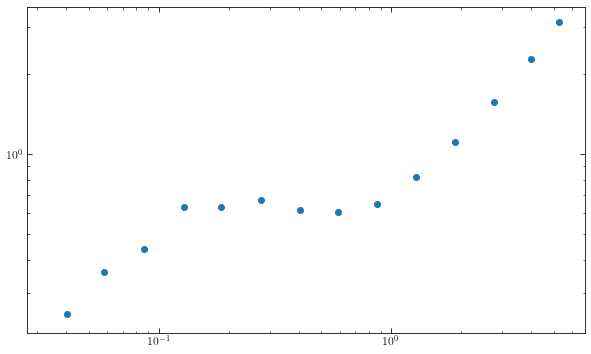

In [200]:
plt.figure(figsize=(10, 6))
plt.scatter(k, ps)
plt.xscale('log')
plt.yscale('log')
plt.show()

## 21cmSense

In [74]:
sensitivity = sense.PowerSpectrum.from_yaml('../sense_configs/sensitivity_hera.yml')
sample = sensitivity.calculate_sensitivity_1d(sample = True, thermal = True)

calculating 2D sensitivity:   0%|          | 0/546 [00:00<?, ?uv-bins/s]/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
calculating 2D sensitivity: 100%|██████████| 546/546 [00:40<00:00, 13.32uv-bins/s]


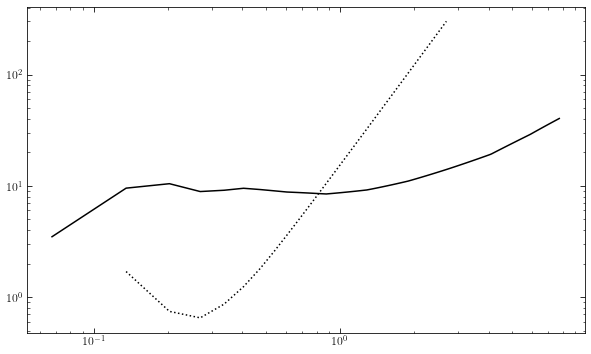

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(sensitivity.k1d, ps1d, 'k:')
plt.plot(sensitivity.k1d, sensitivity.p21(sensitivity.k1d), 'k')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [130]:
ks = np.logspace(np.log10(1.2 * sensitivity.k_min.value), np.log10(0.9 * sensitivity.k_max.value), 115)
err_21cm = interp1d(sensitivity.k1d, ps1d, kind = 'linear')

In [131]:
new_err = err_21cm(ks)
new_err[np.isnan(new_err)] = np.inf

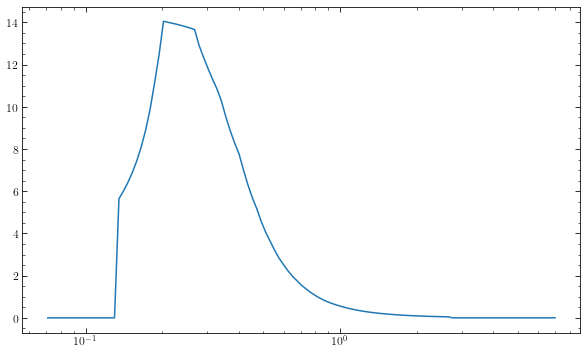

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(ks, sensitivity.p21(ks) / new_err, )
plt.xscale('log')
plt.show()

In [136]:
noise = np.copy(new_err)
noise[np.isinf(noise)] = 1e5

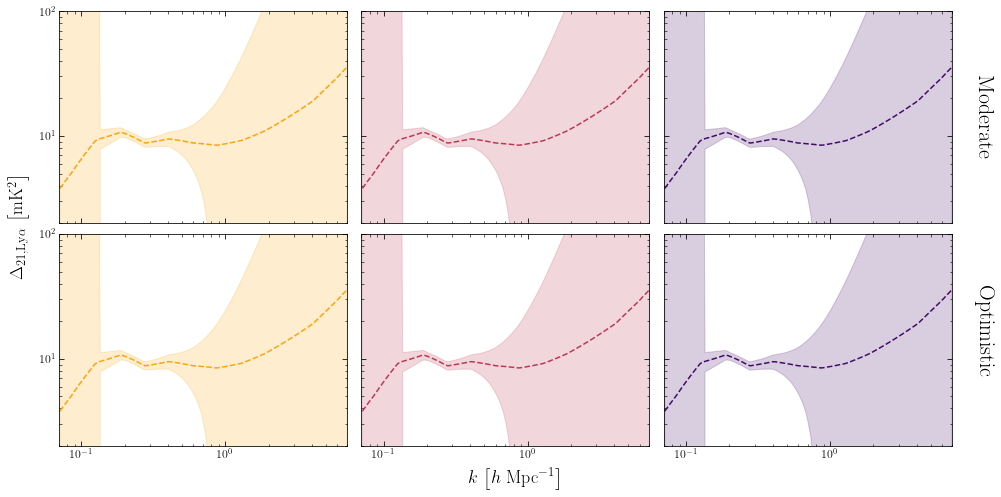

In [218]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharey = True, sharex = True)

axs = ax.ravel()

colors = plt.cm.inferno(np.linspace(0.2, 0.8, 3))[::-1]

for i, ax_i in enumerate(axs):
    ax_i.plot(ks, sensitivity.p21(ks), color = colors[i % 3], linestyle = '--')
    ax_i.fill_between(ks, sensitivity.p21(ks).value - noise,
                     sensitivity.p21(ks).value + noise, alpha = 0.2, color = colors[i % 3])
    ax_i.set_xscale('log')
    ax_i.set_yscale('log')
    ax_i.set_xlim([0.07, 7])
    ax_i.set_ylim([2, 1e2])
    
fig.text(0.48, 0.06, r'$k$ $\left[h \ {\rm Mpc}^{-1} \right]$', fontsize = 18)
fig.text(0.08, 0.42, r'$\Delta_{21, \rm Ly\alpha}$ $\left[\rm mK^2 \right]$', rotation = 90, fontsize = 18)

fig.text(0.92, 0.63, r'Moderate', fontsize = 22, rotation = 270)
fig.text(0.92, 0.25, r'Optimistic', fontsize = 22, rotation = 270)
#fig.tight_layout()   
plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
plt.show()

In [55]:
ps2d = []

keys = list(sample.keys())
keys.sort()

for k in keys:
    ps2d.append(sample[k])
    
ps2d = np.array(ps2d) * u.mK ** 2

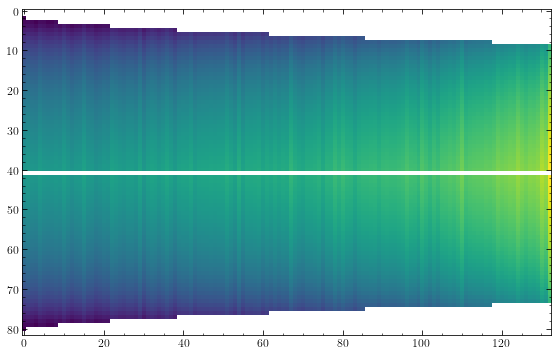

In [58]:
plt.figure(figsize=(10,6))
plt.imshow(np.log10(ps2d.T.value))
plt.show()